Installing & importing necessary libraries

In [ ]:
!pip install transformers datasets accelerate albumentations==1.4.4 opencv-python matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.4/150.4 kB 7.9 MB/s eta 0:00:00
  Attempting uninstall: albumentations
    Found existing installation: albumentations 2.0.8
    Uninstalling albumentations-2.0.8:
      Successfully uninstalled albumentations-2.0.8


In [ ]:
import os
import cv2
import zipfile
import shutil
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from albumentations.pytorch import ToTensorV2
import albumentations as A

from transformers import SegformerForSemanticSegmentation
from google.colab import files

Uploading, extracting & basic details of dataset

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving dedata.zip to dedata.zip


In [ ]:
import zipfile
import os

zip_path = "dedata.zip"  # the file you uploaded
extract_dir = "/content/dedata"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

print("Extracted to:", extract_dir)

Extracted to: /content/dedata


In [ ]:
import os

base = "/content/dedata/dedata"

print("Images:", len(os.listdir(f"{base}/images")))
print("Masks:", len(os.listdir(f"{base}/masks")))

print("\nExample files:")
print(os.listdir(f"{base}/images")[:5])
print(os.listdir(f"{base}/masks")[:5])

Images: 200
Masks: 200

Example files:
['leaf_174.jpg', 'leaf_186.jpg', 'leaf_196.jpg', 'leaf_094.jpg', 'leaf_066.jpg']
['leaf_096.png', 'leaf_169.png', 'leaf_061.png', 'leaf_025.png', 'leaf_093.png']


Splitting the dataset into train, validation and test datasets

In [ ]:
import os, shutil, random

source_images = "/content/dedata/dedata/images"
source_masks  = "/content/dedata/dedata/masks"

output = "/content/split"
os.makedirs(output, exist_ok=True)

for sub in ["train", "val", "test"]:
    os.makedirs(f"{output}/{sub}/images", exist_ok=True)
    os.makedirs(f"{output}/{sub}/masks", exist_ok=True)

files = sorted(os.listdir(source_images))
random.shuffle(files)

n = len(files)
train_files = files[:int(0.8*n)]
val_files   = files[int(0.8*n):int(0.9*n)]
test_files  = files[int(0.9*n):]

def copy_files(file_list, split):
    for f in file_list:
        shutil.copy(f"{source_images}/{f}", f"{output}/{split}/images/{f}")
        shutil.copy(f"{source_masks}/{f[:-4]}.png", f"{output}/{split}/masks/{f[:-4]}.png")

copy_files(train_files, "train")
copy_files(val_files, "val")
copy_files(test_files, "test")

base = "/content/split"

print("Train:", len(os.listdir(base+"/train/images")))
print("Val:", len(os.listdir(base+"/val/images")))
print("Test:", len(os.listdir(base+"/test/images")))

Train: 160
Val: 20
Test: 20


Finding the mask labels

In [ ]:
unique_values = set()

for fname in os.listdir("/content/split/train/masks"):
    m = cv2.imread(os.path.join("/content/split/train/masks", fname), cv2.IMREAD_GRAYSCALE)
    unique_values.update(np.unique(m).tolist())

print("New unique values:", unique_values)

New unique values: {0, 121, 67}


Fix mask labels

In [ ]:
import os
import cv2
import numpy as np

def fix_masks(folder):
    for fname in os.listdir(folder):
        path = os.path.join(folder, fname)
        m = cv2.imread(path, cv2.IMREAD_GRAYSCALE)

        # Convert 67 → 1   and 121 → 2
        m_fixed = np.zeros_like(m)

        m_fixed[m == 67] = 1
        m_fixed[m == 121] = 2
        m_fixed[m == 0] = 0

        cv2.imwrite(path, m_fixed)

# Fix all split folders
fix_masks("/content/split/train/masks")
fix_masks("/content/split/val/masks")
fix_masks("/content/split/test/masks")

print("Mask correction completed!")

Mask correction completed!


Verifying the corrected mask labels

In [ ]:
unique_values = set()

for fname in os.listdir("/content/split/train/masks"):
    m = cv2.imread(os.path.join("/content/split/train/masks", fname), cv2.IMREAD_GRAYSCALE)
    unique_values.update(np.unique(m).tolist())

print("New unique values:", unique_values)

New unique values: {0, 1, 2}


Define Data Augmentation Pipeline

In [ ]:
train_tf = A.Compose([
    A.Resize(512, 512),
    A.Affine(rotate=(-20, 20), translate_percent=(0.1, 0.1),
             scale=(0.9, 1.1), p=0.7),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.3),
    A.RandomRotate90(p=0.5),
    A.GaussNoise(noise_limit=0.05, p=0.4),
    A.MotionBlur(blur_limit=7, p=0.3),
    A.RandomBrightnessContrast(p=0.5),
    A.GridDistortion(num_steps=5, distort_limit=0.3, p=0.4),
    A.ElasticTransform(alpha=20, sigma=30, p=0.3),
    A.CoarseDropout(max_holes=8, max_height=32, max_width=32,
                    min_holes=2, fill_value=0, mask_fill_value=0, p=0.5),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2(),
])

val_tf = A.Compose([
    A.Resize(512, 512),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2(),
])

Creating Custom Dataset Class, Initializing Datasets and Creating Dataloaders

In [ ]:
class LeafSegmentationDataset(Dataset):
    def __init__(self, root_dir, transforms=None):
        self.root = root_dir
        self.images = sorted(os.listdir(f"{root_dir}/images"))
        self.masks = sorted(os.listdir(f"{root_dir}/masks"))
        self.transforms = transforms

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = f"{self.root}/images/{self.images[idx]}"
        mask_path = f"{self.root}/masks/{self.masks[idx]}"

        image = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        if self.transforms:
            aug = self.transforms(image=image, mask=mask)
            return aug["image"], aug["mask"].long()

        return image, mask

train_dataset = LeafSegmentationDataset("/content/split/train", train_tf)
val_dataset   = LeafSegmentationDataset("/content/split/val", val_tf)
test_dataset  = LeafSegmentationDataset("/content/split/test", val_tf)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=8, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=8, shuffle=False)

Loading SegFormer-B0 Pretrained Model

In [ ]:
model = SegformerForSemanticSegmentation.from_pretrained(
    "nvidia/segformer-b0-finetuned-ade-512-512",
    num_labels=3,
    ignore_mismatched_sizes=True
).to("cuda")

print("Model loaded (no training yet).")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/15.0M [00:00<?, ?B/s]

Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/segformer-b0-finetuned-ade-512-512 and are newly initialized because the shapes did not match:
- decode_head.classifier.bias: found shape torch.Size([150]) in the checkpoint and torch.Size([3]) in the model instantiated
- decode_head.classifier.weight: found shape torch.Size([150, 256, 1, 1]) in the checkpoint and torch.Size([3, 256, 1, 1]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model loaded (no training yet).


Qualitative Results Before Training

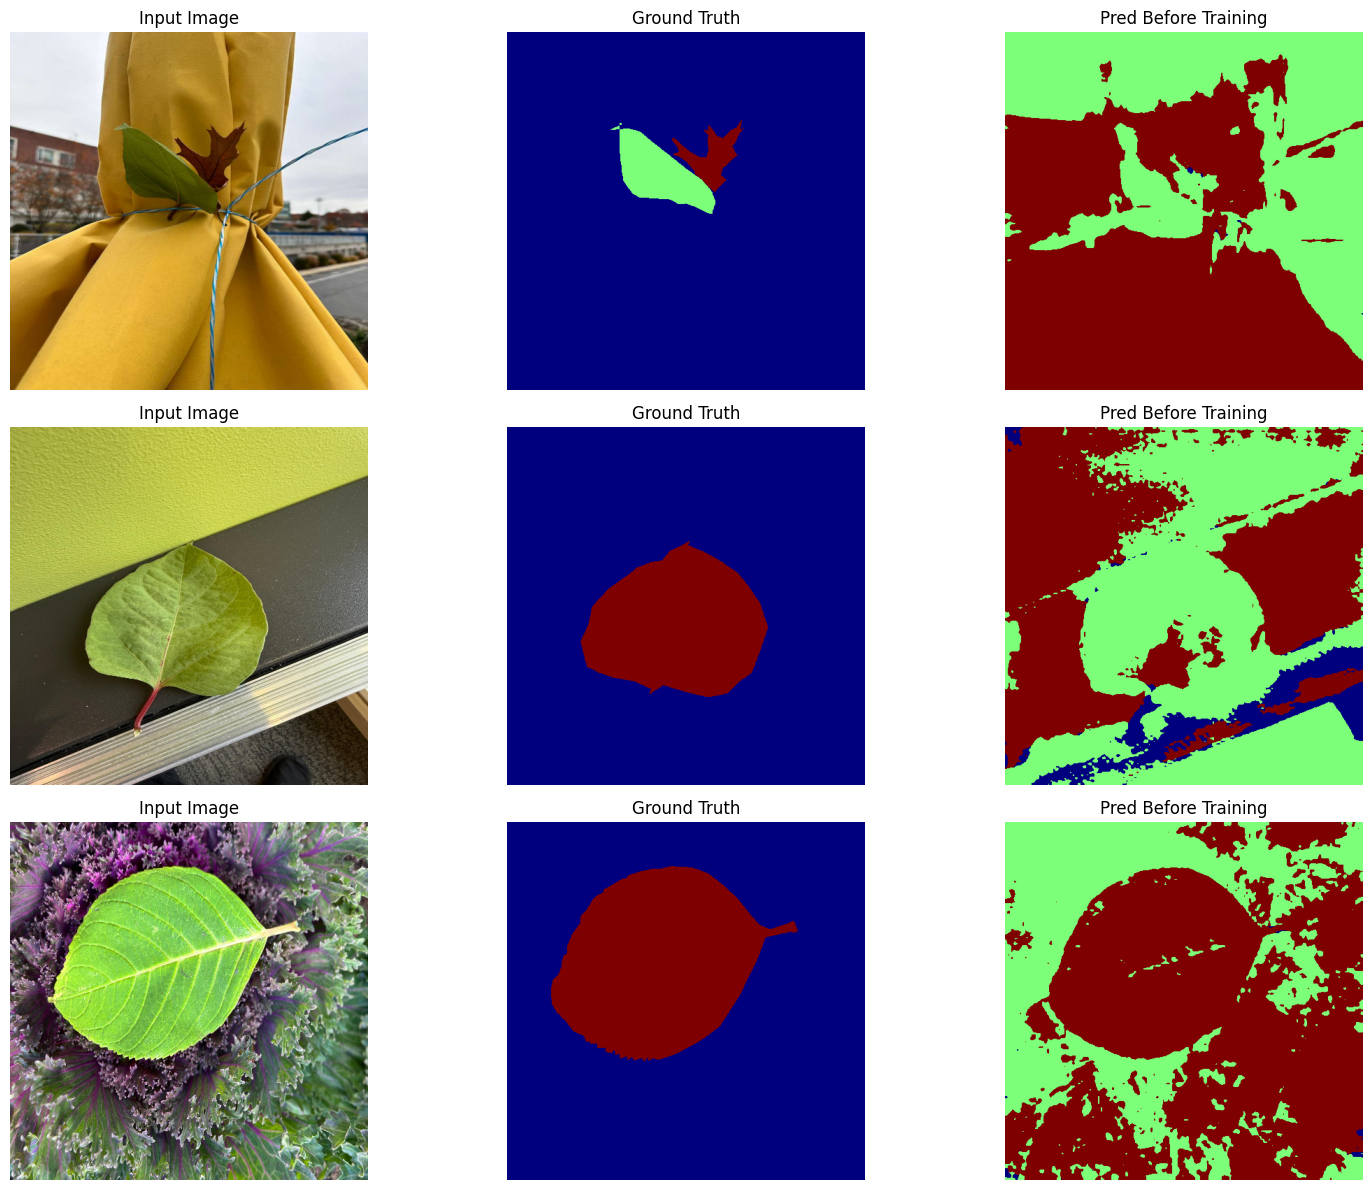

In [ ]:
def vis_initial(model, dataset, num_samples=3):
    model.eval()
    import torch.nn.functional as F

    idxs = random.sample(range(len(dataset)), num_samples)

    plt.figure(figsize=(16, num_samples * 4))

    with torch.no_grad():
        for i, idx in enumerate(idxs):
            img, gt = dataset[idx]
            img_gpu = img.unsqueeze(0).to("cuda")

            out = model(pixel_values=img_gpu)
            logits = out.logits

            logits_up = F.interpolate(logits, size=gt.shape, mode="bilinear", align_corners=False)
            pred = torch.argmax(logits_up, 1).squeeze().cpu()

            mean = torch.tensor([0.485, 0.456, 0.406]).view(3,1,1)
            std  = torch.tensor([0.229, 0.224, 0.225]).view(3,1,1)
            img_n = img.cpu() * std + mean
            img_n = img_n.permute(1,2,0).numpy().clip(0,1)

            plt.subplot(num_samples, 3, 3*i + 1)
            plt.imshow(img_n); plt.axis("off"); plt.title("Input Image")

            plt.subplot(num_samples, 3, 3*i + 2)
            plt.imshow(gt, cmap="jet"); plt.axis("off"); plt.title("Ground Truth")

            plt.subplot(num_samples, 3, 3*i + 3)
            plt.imshow(pred, cmap="jet"); plt.axis("off"); plt.title("Pred Before Training")

    plt.tight_layout()
    plt.show()

vis_initial(model, val_dataset, num_samples=3)

In [ ]:
# Loss function for evaluation & CE training
criterion = torch.nn.CrossEntropyLoss()

def mean_iou(pred, label, num_classes=3):
    pred = pred.flatten()
    label = label.flatten()
    ious = []
    for cls in range(num_classes):
        inter = ((pred == cls) & (label == cls)).sum().item()
        union = ((pred == cls) | (label == cls)).sum().item()
        ious.append(inter / union if union else 1)
    return np.mean(ious)

def evaluate(loader):
    model.eval()
    losses, ious = [], []

    with torch.no_grad():
        for imgs, masks in loader:
            imgs = imgs.to("cuda")
            masks = masks.to("cuda")

            outputs = model(pixel_values=imgs)
            logits = outputs.logits

            logits_up = F.interpolate(
                logits,
                size=masks.shape[1:],
                mode="bilinear",
                align_corners=False
            )

            loss = criterion(logits_up, masks)
            losses.append(loss.item())

            preds = torch.argmax(logits_up, dim=1)
            ious.append(mean_iou(preds.cpu(), masks.cpu()))

    return float(np.mean(losses)), float(np.mean(ious))

Hyperparameter Search

In [ ]:
search_space = {
    "lr": [1e-5, 5e-5, 1e-4, 5e-4],
    "batch": [4, 8, 16],
    "wd": [0.0, 0.01, 0.05],
    "opt": ["adamw", "sgd"]
}

def run_trial(hp):
    lr, bs, wd, opt = hp["lr"], hp["batch"], hp["wd"], hp["opt"]

    print(f"Testing: LR={lr}, BS={bs}, WD={wd}, OPT={opt}")

    loader = DataLoader(train_dataset, batch_size=bs, shuffle=True)

    model_t = SegformerForSemanticSegmentation.from_pretrained(
        "nvidia/segformer-b0-finetuned-ade-512-512",
        num_labels=3,
        ignore_mismatched_sizes=True
    ).to("cuda")

    optimizer = (
        torch.optim.AdamW(model_t.parameters(), lr=lr, weight_decay=wd)
        if opt == "adamw" else
        torch.optim.SGD(model_t.parameters(), lr=lr, momentum=0.9, weight_decay=wd)
    )

    imgs, masks = next(iter(loader))
    imgs, masks = imgs.to("cuda"), masks.to("cuda")

    out = model_t(pixel_values=imgs, labels=masks)
    loss = out.loss
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    val_loss, val_iou = evaluate(val_loader)

    return val_loss, val_iou

results = []
for i in range(10):
    hp = {k: random.choice(v) for k, v in search_space.items()}
    loss, iou = run_trial(hp)
    results.append((hp, loss, iou))

best = sorted(results, key=lambda x: x[1])[0]
best_params = best[0]

best_lr  = best_params["lr"]
best_bs  = best_params["batch"]
best_wd  = best_params["wd"]
best_opt = best_params["opt"]

if best_opt == "sgd" and best_lr < 1e-4:
    print("Fixing invalid tuning result: switching to AdamW (lr=1e-4)")
    best_opt = "adamw"
    best_lr = 1e-4

print("\nBest Hyperparameters:", best_params)

Testing: LR=0.0005, BS=4, WD=0.01, OPT=sgd


Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/segformer-b0-finetuned-ade-512-512 and are newly initialized because the shapes did not match:
- decode_head.classifier.bias: found shape torch.Size([150]) in the checkpoint and torch.Size([3]) in the model instantiated
- decode_head.classifier.weight: found shape torch.Size([150, 256, 1, 1]) in the checkpoint and torch.Size([3, 256, 1, 1]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Testing: LR=0.0005, BS=8, WD=0.05, OPT=sgd


Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/segformer-b0-finetuned-ade-512-512 and are newly initialized because the shapes did not match:
- decode_head.classifier.bias: found shape torch.Size([150]) in the checkpoint and torch.Size([3]) in the model instantiated
- decode_head.classifier.weight: found shape torch.Size([150, 256, 1, 1]) in the checkpoint and torch.Size([3, 256, 1, 1]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Testing: LR=1e-05, BS=4, WD=0.0, OPT=adamw


Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/segformer-b0-finetuned-ade-512-512 and are newly initialized because the shapes did not match:
- decode_head.classifier.bias: found shape torch.Size([150]) in the checkpoint and torch.Size([3]) in the model instantiated
- decode_head.classifier.weight: found shape torch.Size([150, 256, 1, 1]) in the checkpoint and torch.Size([3, 256, 1, 1]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Testing: LR=5e-05, BS=8, WD=0.05, OPT=adamw


Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/segformer-b0-finetuned-ade-512-512 and are newly initialized because the shapes did not match:
- decode_head.classifier.bias: found shape torch.Size([150]) in the checkpoint and torch.Size([3]) in the model instantiated
- decode_head.classifier.weight: found shape torch.Size([150, 256, 1, 1]) in the checkpoint and torch.Size([3, 256, 1, 1]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Testing: LR=0.0001, BS=16, WD=0.0, OPT=sgd


Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/segformer-b0-finetuned-ade-512-512 and are newly initialized because the shapes did not match:
- decode_head.classifier.bias: found shape torch.Size([150]) in the checkpoint and torch.Size([3]) in the model instantiated
- decode_head.classifier.weight: found shape torch.Size([150, 256, 1, 1]) in the checkpoint and torch.Size([3, 256, 1, 1]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Testing: LR=1e-05, BS=16, WD=0.0, OPT=sgd


Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/segformer-b0-finetuned-ade-512-512 and are newly initialized because the shapes did not match:
- decode_head.classifier.bias: found shape torch.Size([150]) in the checkpoint and torch.Size([3]) in the model instantiated
- decode_head.classifier.weight: found shape torch.Size([150, 256, 1, 1]) in the checkpoint and torch.Size([3, 256, 1, 1]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Testing: LR=0.0001, BS=16, WD=0.0, OPT=adamw


Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/segformer-b0-finetuned-ade-512-512 and are newly initialized because the shapes did not match:
- decode_head.classifier.bias: found shape torch.Size([150]) in the checkpoint and torch.Size([3]) in the model instantiated
- decode_head.classifier.weight: found shape torch.Size([150, 256, 1, 1]) in the checkpoint and torch.Size([3, 256, 1, 1]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Testing: LR=5e-05, BS=4, WD=0.0, OPT=adamw


Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/segformer-b0-finetuned-ade-512-512 and are newly initialized because the shapes did not match:
- decode_head.classifier.bias: found shape torch.Size([150]) in the checkpoint and torch.Size([3]) in the model instantiated
- decode_head.classifier.weight: found shape torch.Size([150, 256, 1, 1]) in the checkpoint and torch.Size([3, 256, 1, 1]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Testing: LR=1e-05, BS=4, WD=0.05, OPT=adamw


Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/segformer-b0-finetuned-ade-512-512 and are newly initialized because the shapes did not match:
- decode_head.classifier.bias: found shape torch.Size([150]) in the checkpoint and torch.Size([3]) in the model instantiated
- decode_head.classifier.weight: found shape torch.Size([150, 256, 1, 1]) in the checkpoint and torch.Size([3, 256, 1, 1]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Testing: LR=5e-05, BS=8, WD=0.0, OPT=sgd


Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/segformer-b0-finetuned-ade-512-512 and are newly initialized because the shapes did not match:
- decode_head.classifier.bias: found shape torch.Size([150]) in the checkpoint and torch.Size([3]) in the model instantiated
- decode_head.classifier.weight: found shape torch.Size([150, 256, 1, 1]) in the checkpoint and torch.Size([3, 256, 1, 1]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Best Hyperparameters: {'lr': 0.0005, 'batch': 4, 'wd': 0.01, 'opt': 'sgd'}


CE Training

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=best_bs, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=best_bs, shuffle=False)

if best_opt == "adamw":
    optimizer = torch.optim.AdamW(model.parameters(), lr=best_lr, weight_decay=best_wd)
else:
    optimizer = torch.optim.SGD(model.parameters(), lr=best_lr, momentum=0.9, weight_decay=best_wd)

train_loss_history = []
val_loss_history = []
val_iou_history  = []

EPOCHS = 10

for epoch in range(EPOCHS):
    model.train()
    total_loss = 0

    for imgs, masks in train_loader:
        imgs = imgs.to("cuda")
        masks = masks.to("cuda")

        outputs = model(pixel_values=imgs)
        logits = outputs.logits

        logits_up = F.interpolate(logits, size=masks.shape[1:], mode="bilinear", align_corners=False)

        loss = criterion(logits_up, masks)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    val_loss, val_iou = evaluate(val_loader)

    train_loss_history.append(total_loss)
    val_loss_history.append(val_loss)
    val_iou_history.append(val_iou)

    print(f"Epoch {epoch+1}/{EPOCHS} | TrainLoss={total_loss:.4f} | ValLoss={val_loss:.4f} | ValIoU={val_iou:.4f}")

Epoch 1/10 | TrainLoss=24.0150 | ValLoss=0.3129 | ValIoU=0.3719
Epoch 2/10 | TrainLoss=12.6611 | ValLoss=0.2532 | ValIoU=0.3719
Epoch 3/10 | TrainLoss=10.3917 | ValLoss=0.2244 | ValIoU=0.3738
Epoch 4/10 | TrainLoss=9.5156 | ValLoss=0.2014 | ValIoU=0.4744
Epoch 5/10 | TrainLoss=8.0437 | ValLoss=0.1843 | ValIoU=0.5339
Epoch 6/10 | TrainLoss=7.5055 | ValLoss=0.1732 | ValIoU=0.5214
Epoch 7/10 | TrainLoss=6.7002 | ValLoss=0.1606 | ValIoU=0.5084
Epoch 8/10 | TrainLoss=6.3285 | ValLoss=0.1521 | ValIoU=0.5095
Epoch 9/10 | TrainLoss=5.8843 | ValLoss=0.1448 | ValIoU=0.5351
Epoch 10/10 | TrainLoss=5.5330 | ValLoss=0.1387 | ValIoU=0.5608


Plots for CE

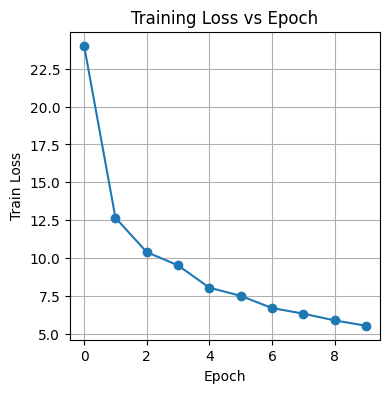

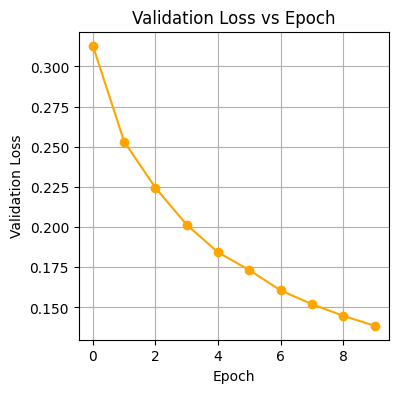

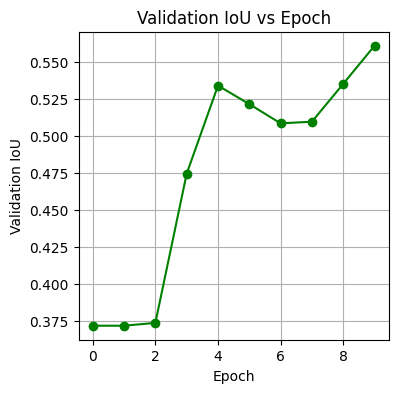

In [ ]:
plt.figure(figsize=(4,4))
plt.plot(train_loss_history, marker='o')
plt.title("Training Loss vs Epoch")
plt.xlabel("Epoch")
plt.ylabel("Train Loss")
plt.grid(True)
plt.show()

plt.figure(figsize=(4,4))
plt.plot(val_loss_history, marker='o', color='orange')
plt.title("Validation Loss vs Epoch")
plt.xlabel("Epoch")
plt.ylabel("Validation Loss")
plt.grid(True)
plt.show()

plt.figure(figsize=(4,4))
plt.plot(val_iou_history, marker='o', color='green')
plt.title("Validation IoU vs Epoch")
plt.xlabel("Epoch")
plt.ylabel("Validation IoU")
plt.grid(True)
plt.show()

Confusion Matrix

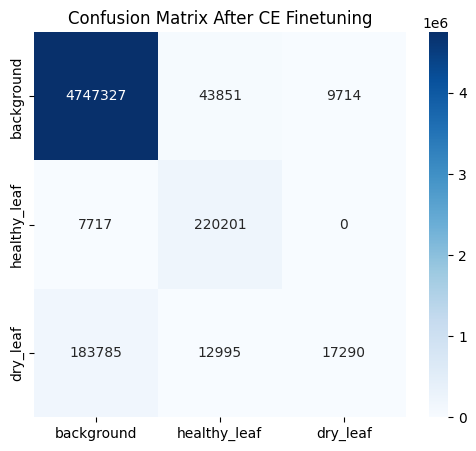

In [ ]:
from sklearn.metrics import confusion_matrix

def compute_confusion_matrix(model, loader, num_classes=3):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for imgs, masks in loader:
            imgs = imgs.to("cuda")
            masks = masks.to("cuda")

            outputs = model(pixel_values=imgs)
            logits = outputs.logits

            logits_up = F.interpolate(
                logits,
                size=masks.shape[1:],
                mode="bilinear",
                align_corners=False
            )

            preds = torch.argmax(logits_up, dim=1)

            all_preds.extend(preds.cpu().numpy().flatten())
            all_labels.extend(masks.cpu().numpy().flatten())

    cm = confusion_matrix(all_labels, all_preds, labels=[0,1,2])
    return cm

cm_ce = compute_confusion_matrix(model, val_loader)

plt.figure(figsize=(6,5))
sns.heatmap(cm_ce, annot=True, fmt="d", cmap="Blues",
            xticklabels=["background","healthy_leaf","dry_leaf"],
            yticklabels=["background","healthy_leaf","dry_leaf"])
plt.title("Confusion Matrix After CE Finetuning")
plt.show()

Qualitative Results After CE

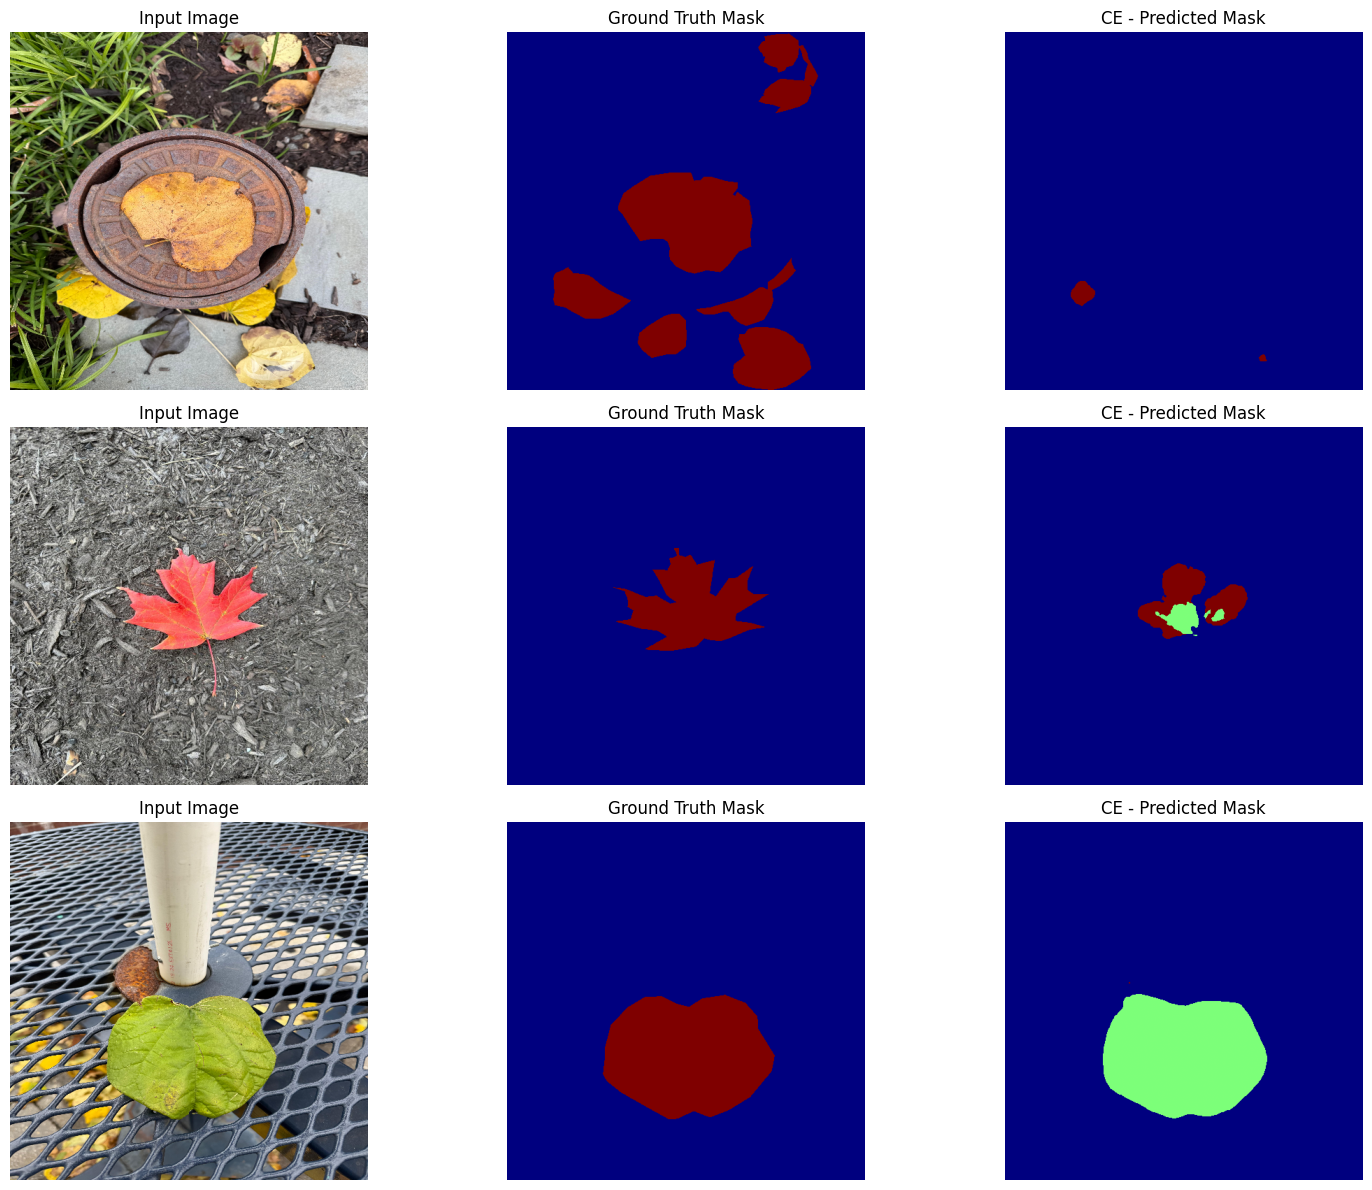

In [ ]:
def visualize_qualitative_results(model, dataset, num_samples=4, title_prefix="CE Results"):
    model.eval()
    indices = random.sample(range(len(dataset)), num_samples)

    plt.figure(figsize=(16, num_samples * 4))

    with torch.no_grad():
        for i, idx in enumerate(indices):
            img, gt_mask = dataset[idx]
            img_gpu = img.unsqueeze(0).to("cuda")

            outputs = model(pixel_values=img_gpu)
            logits = outputs.logits

            logits_up = F.interpolate(
                logits,
                size=gt_mask.shape,
                mode="bilinear",
                align_corners=False
            )

            pred_mask = torch.argmax(logits_up, dim=1).squeeze().cpu()

            mean = torch.tensor([0.485, 0.456, 0.406]).view(3,1,1)
            std  = torch.tensor([0.229, 0.224, 0.225]).view(3,1,1)
            img_n = img.cpu() * std + mean
            img_n = img_n.permute(1,2,0).numpy().clip(0,1)

            plt.subplot(num_samples, 3, 3*i + 1)
            plt.imshow(img_n)
            plt.title("Input Image")
            plt.axis("off")

            plt.subplot(num_samples, 3, 3*i + 2)
            plt.imshow(gt_mask.cpu(), cmap="jet")
            plt.title("Ground Truth Mask")
            plt.axis("off")

            plt.subplot(num_samples, 3, 3*i + 3)
            plt.imshow(pred_mask, cmap="jet")
            plt.title(f"{title_prefix} - Predicted Mask")
            plt.axis("off")

    plt.tight_layout()
    plt.show()

visualize_qualitative_results(model, val_dataset, num_samples=3, title_prefix="CE")

Save CE Model

In [ ]:
torch.save(model.state_dict(), "segformer_ce_finetuned.pth")
print("Saved CE model!")

Saved CE model!


Load CE Model

In [ ]:
model.load_state_dict(torch.load("segformer_ce_finetuned.pth"))
model = model.to("cuda")
print("Loaded CE weights! Ready for Dice training.")

Loaded CE weights! Ready for Dice training.


Dice + CE Combined Loss

In [ ]:
ce_loss = torch.nn.CrossEntropyLoss()

def dice_loss(pred, target, smooth=1e-6):
    pred_soft = torch.softmax(pred, dim=1)

    num_classes = pred.shape[1]
    total_loss = 0

    for cls in range(num_classes):
        pred_cls = pred_soft[:, cls, :, :]
        target_cls = (target == cls).float()

        intersection = (pred_cls * target_cls).sum()
        union = pred_cls.sum() + target_cls.sum()

        dice = 1 - (2 * intersection + smooth) / (union + smooth)
        total_loss += dice

    return total_loss / num_classes

def combined_loss(logits_up, masks, alpha=0.5):
    ce = ce_loss(logits_up, masks)
    dsc = dice_loss(logits_up, masks)
    return alpha*ce + (1-alpha)*dsc

Dice Finetuning

In [ ]:
EPOCHS = 5

for epoch in range(EPOCHS):
    model.train()
    total_loss = 0

    for imgs, masks in train_loader:
        imgs = imgs.to("cuda")
        masks = masks.to("cuda")

        outputs = model(pixel_values=imgs)
        logits = outputs.logits

        logits_up = F.interpolate(
            logits, size=masks.shape[1:], mode="bilinear", align_corners=False
        )

        loss = combined_loss(logits_up, masks)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    val_loss, val_iou = evaluate(val_loader)
    print(f"Epoch {epoch+1}/{EPOCHS} | TrainLoss={total_loss:.4f} | ValLoss={val_loss:.4f} | ValIoU={val_iou:.4f}")

Epoch 1/5 | TrainLoss=10.8750 | ValLoss=0.1313 | ValIoU=0.6172
Epoch 2/5 | TrainLoss=9.9784 | ValLoss=0.1280 | ValIoU=0.7303
Epoch 3/5 | TrainLoss=9.0329 | ValLoss=0.1200 | ValIoU=0.7474
Epoch 4/5 | TrainLoss=8.0541 | ValLoss=0.1223 | ValIoU=0.7441
Epoch 5/5 | TrainLoss=7.8329 | ValLoss=0.1165 | ValIoU=0.7615


Confusion Matrix After Dice

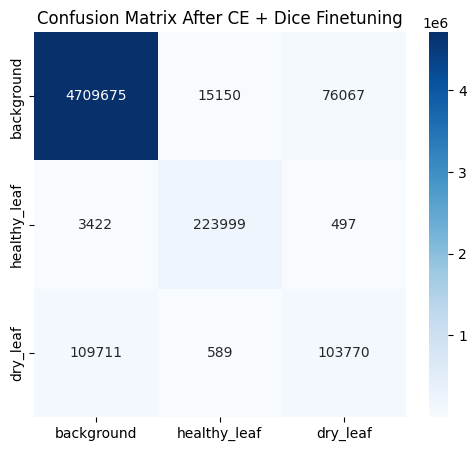

In [ ]:
cm_dice = compute_confusion_matrix(model, val_loader)

plt.figure(figsize=(6,5))
sns.heatmap(cm_dice, annot=True, fmt="d", cmap="Blues",
            xticklabels=["background","healthy_leaf","dry_leaf"],
            yticklabels=["background","healthy_leaf","dry_leaf"])
plt.title("Confusion Matrix After CE + Dice Finetuning")
plt.show()

Qualitative Results after Dice

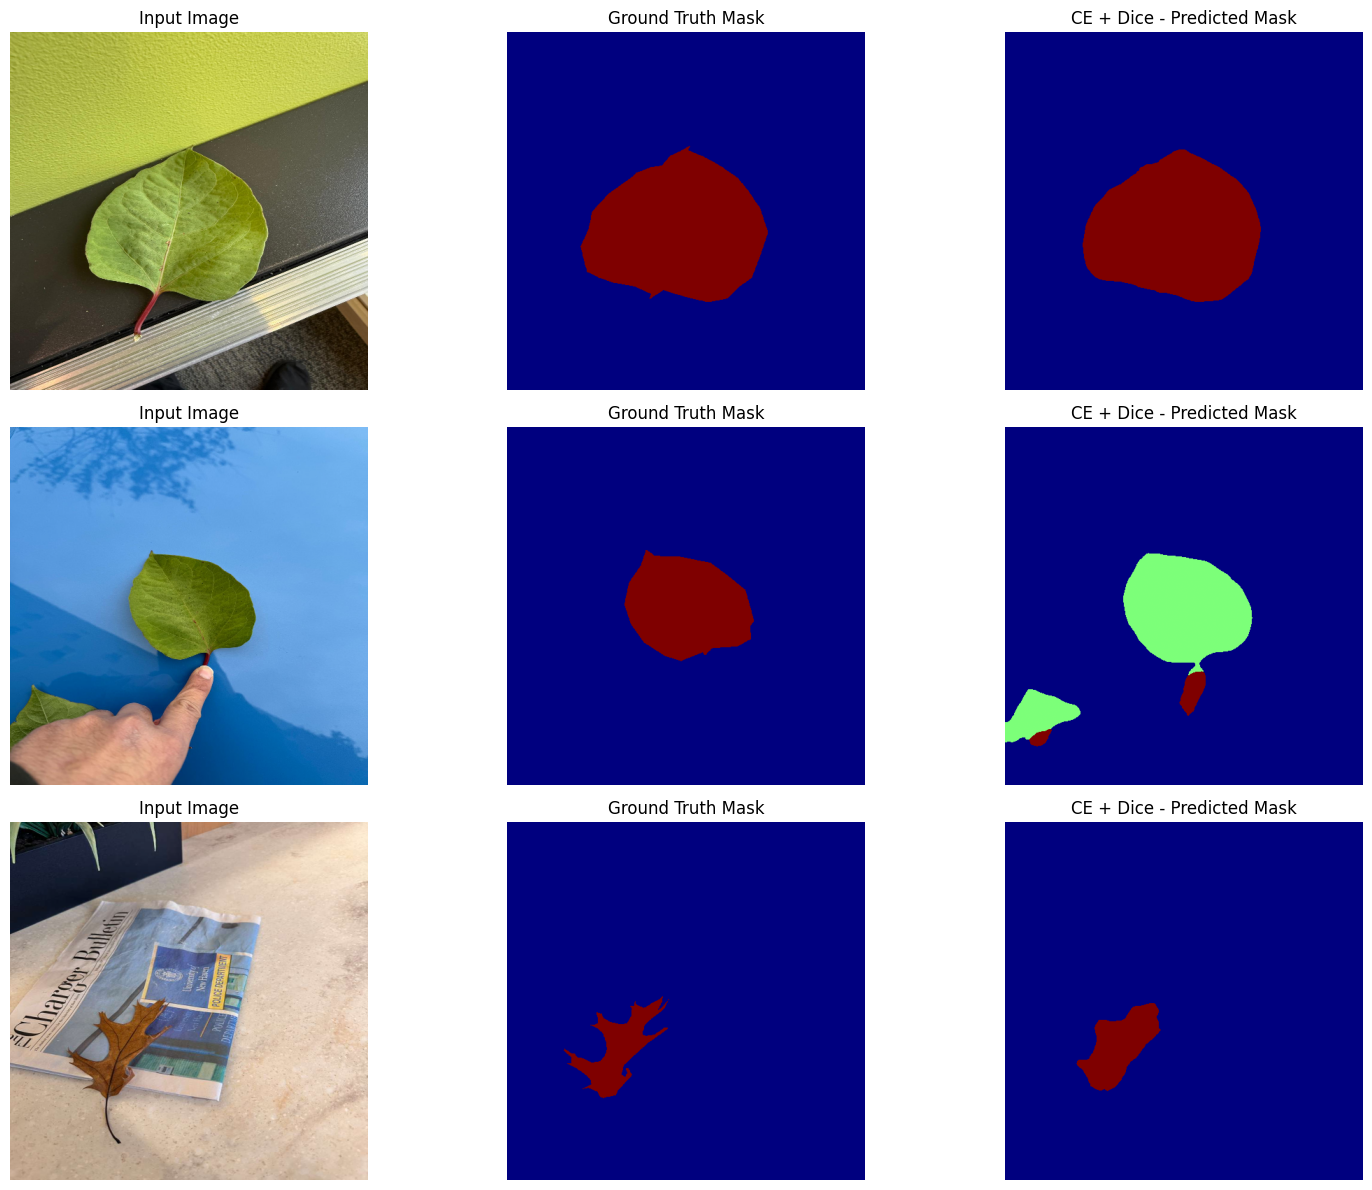

In [ ]:
visualize_qualitative_results(model, val_dataset, num_samples=3, title_prefix="CE + Dice")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

save_path = "/content/drive/MyDrive/leaf_segformer_model"

model.save_pretrained(save_path)
print("Model saved at:", save_path)

Mounted at /content/drive
Model saved at: /content/drive/MyDrive/leaf_segformer_model


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

load_path = "/content/drive/MyDrive/leaf_segformer_model"

from transformers import SegformerForSemanticSegmentation

model = SegformerForSemanticSegmentation.from_pretrained(load_path).to("cuda")
model.eval()

print("Model loaded successfully!")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Model loaded successfully!


In [ ]:
import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
import albumentations as A
from albumentations.pytorch import ToTensorV2

# Same transforms as validation
infer_tf = A.Compose([
    A.Resize(512, 512),
    A.Normalize(mean=(0.485, 0.456, 0.406),
                std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

def predict_single_image(model, img_path):
    # Load image
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Apply transforms
    aug = infer_tf(image=img)
    tensor = aug["image"].unsqueeze(0).to("cuda")

    # Forward pass
    with torch.no_grad():
        outputs = model(pixel_values=tensor)
        logits = outputs.logits

        # Upsample to original size
        upsampled = F.interpolate(
            logits,
            size=(img.shape[0], img.shape[1]),
            mode="bilinear",
            align_corners=False
        )

        pred = torch.argmax(upsampled, dim=1)[0].cpu().numpy()

    # Visualization
    plt.figure(figsize=(12,5))

    plt.subplot(1,2,1)
    plt.imshow(img)
    plt.title("Input Image")
    plt.axis("off")

    plt.subplot(1,2,2)
    plt.imshow(pred, cmap="jet")
    plt.title("Predicted Mask")
    plt.axis("off")

    plt.show()

    return pred

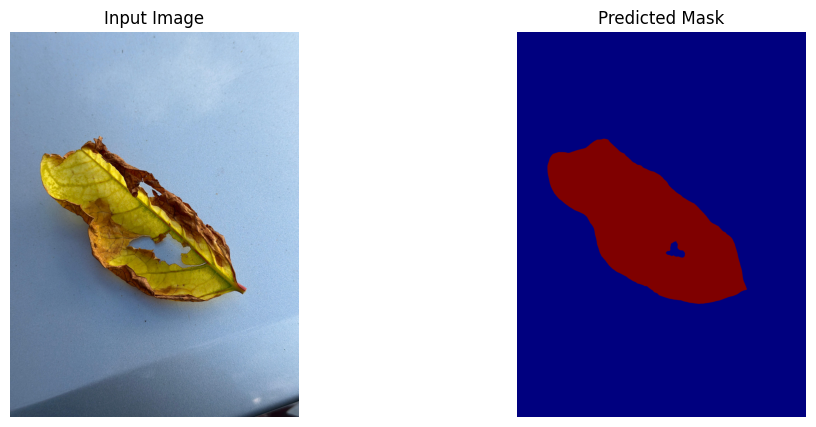

In [ ]:
pred_mask = predict_single_image(model, "/content/split/test/images/leaf_008.jpg")

In [ ]:
import shutil

src_dataset = "/content/split"
dst_dataset = "/content/drive/MyDrive/leaf_dataset"

# Copy entire dataset to drive
shutil.copytree(src_dataset, dst_dataset, dirs_exist_ok=True)

print("Dataset copied to Google Drive!")

Dataset copied to Google Drive!
